In [1]:
# Class to Create and Forecast time series using Amazon Chronos

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import json
import torch
import random
import transformers
from statsmodels.tsa.seasonal import seasonal_decompose
from chronos import ChronosPipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from gluonts.dataset.repository import get_dataset
from gluonts.dataset.split import split
from gluonts.ev.metrics import MASE, MeanWeightedSumQuantileLoss
from gluonts.itertools import batcher
from gluonts.model.evaluation import evaluate_forecasts
from gluonts.model.forecast import SampleForecast
from gluonts.dataset.common import ListDataset
from tqdm.auto import tqdm


class ChronosForecaster:

    def __init__(self) -> None:
        transformers.set_seed(42)
        self.limit_pred_len = True
        pass

    @staticmethod
    def is_gpu():
        return torch.cuda.is_available()
    
    def get_series_decomposition(self, series, model='additive', period=12):
        result = seasonal_decompose(series, model=model, period=period)
        result.plot()
        return result

    def calculate_metrics(self, predicted, ground_truth):
        mae = mean_absolute_error(ground_truth, predicted)
        mse = mean_squared_error(ground_truth, predicted)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(ground_truth, predicted)
        r_squared = r2_score(ground_truth, predicted)

        return {
            'MAE': round(mae,2),
            'MSE': round(mse,2),
            'RMSE': round(rmse,2),
            'MAPE': round(mape,2),
            'R-squared': round(r_squared,2),
        }
    
    # Split by percentage
    def split_train_test(self, df, test_size=0.2, limit_pred_length=True):
        self.df = df
        _, _, self.y_train, self.y_test = train_test_split(df, df, test_size=test_size, random_state=42, shuffle=False)
        clipped = False
        self.limit_pred_len = limit_pred_length
        if len(self.y_test) > 64 and self.limit_pred_len:
            print(f"[!] Test array size is {len(self.y_test)} which is > 64!")
            print("Clipping test data size to first 64 samples for acceptable accuracy")
            self.y_test = self.y_test[:64]
            self.y_train = self.y_train[:-len(self.y_test)]
            clipped = True
        else:
            print('[!] WARNING: limit_pred_length is disabled! Far future prediction will have low accuracy!')
        return self.y_train, self.y_test, clipped
    
    # Split by number of samples to be predicted
    def split_train_test_by_sample_size(self, df, target_column, test_sample_size=24):
        self.df = df
        self.y_test:pd.DataFrame = df.iloc[-test_sample_size:][target_column]
        self.y_train:pd.DataFrame = df.iloc[:len(df)-test_sample_size][target_column]
        self.limit_pred_len = False
        return self.y_train, self.y_test

    def predict(self, model_name="amazon/chronos-t5-small", num_samples=20, temp=1, top_k=50, top_p=1, debug=True):
        device = "cuda"
        self.pipeline = ChronosPipeline.from_pretrained(
            model_name,
            device_map=device,
            torch_dtype=torch.bfloat16
        )
        try:
            context = torch.tensor(self.y_train)
        except ValueError:
            context = torch.tensor(self.y_train.astype(float).values)
        prediction_length = len(self.y_test)
        if debug:
            print(f"Using {device}\nContext length = {len(self.y_train)}\nForecast length = {prediction_length}\nSample size = {num_samples}")
        self.forecast = self.pipeline.predict(
            context,
            prediction_length,
            num_samples=num_samples,
            temperature=temp,
            top_k=int(top_k),
            top_p=top_p,
            limit_prediction_length=self.limit_pred_len
        )

        # self.forecast_index = range(len(self.y_train), len(self.y_train) + prediction_length)
        self.forecast_index = range(self.y_test.index[0], self.y_test.index[-1] + 1)
        self.low, self.median, self.high = np.quantile(self.forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
        # self.median = self.forecast[0].numpy().mean(axis=0)           # Mean instead of median
        self.metrics = self.calculate_metrics(self.median, self.y_test)
        self.params = json.dumps({
                "model": model_name,
                "top_p": top_p,
                "top_k": top_k,
                "tempearature": temp,
                "num_samples": num_samples,
                "context_length": len(self.y_train),
                "prediction_length": prediction_length
            },
            indent=2)

        return (self.forecast, self.metrics, self.median)
    
    def plot_forecast(self, series:pd.Series):
        plt.figure(figsize=(8, 4))
        plt.plot(series, color="royalblue", label="Historical Data")
        plt.plot(self.y_test, color="green", label="Ground Truth")
        plt.plot(self.forecast_index, self.median, color="tomato", label="Median Forecast")
        plt.fill_between(self.forecast_index, self.low, self.high, color="tomato", alpha=0.3, label="80% Prediction Interval")
        plt.title('CHRONOS Forecasting')
        plt.figtext(1, 0.55, "Metrics:\n" + json.dumps(self.metrics, indent=2))
        plt.figtext(1, 0.1, "Params:\n" + self.params)
        plt.legend()
        plt.grid()
        return plt

    # Run tunning experiments for model param optimisation
    def tune_model(self, num_iterations, series, metric_name='MSE'):
        list_metrics = []

        for i in range(num_iterations):
            model_name = random.choice(["amazon/chronos-t5-small"])
            top_p = random.randint(10, 100)
            top_k = round(random.randrange(1,10,1)/10,1)
            temp = round(random.randrange(1,10,1)/10,1)
            num_samples = random.randint(9,51)

            print(f'Running iteration {i} -> top_p = {top_p}, top_k = {top_k}, temp = {temp}, num_samples = {num_samples}')
            
            _, result, _ = self.predict(
                model_name=model_name,
                num_samples=num_samples,
                temp=temp,
                top_k=top_k,
                top_p=top_p,
                debug=False
            )

            plot = self.plot_forecast(series)
            plot.savefig(f'results/{series.name}-{i}.png', bbox_inches='tight')
            plot.close()

            result['filename'] = f'results/{series.name}-{i}.png'

            list_metrics.append(result | json.loads(self.params))

        return pd.DataFrame(sorted(list_metrics, key=lambda x: x[metric_name]))

/home/yogi/miniconda3/envs/chronos-zero-shot/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running with idx = 5350


Using cuda
Context length = 1500
Forecast length = 64
Sample size = 3
token=  tensor([[2132, 2128, 2127, 2126, 2128, 2127, 2126, 2126, 2125, 2125, 2125, 2126,
         2125, 2126, 2126, 2125, 2124, 2125, 2124, 2121, 2119, 2119, 2122, 2121,
         2122, 2124, 2124, 2126, 2126, 2126, 2126, 2128, 2129, 2129, 2126, 2126,
         2126, 2126, 2126, 2126, 2127, 2126, 2127, 2127, 2127, 2127, 2128, 2131,
         2130, 2133, 2131, 2131, 2130, 2128, 2126, 2127, 2127, 2123, 2123, 2120,
         2121, 2122, 2119, 2119, 2119, 2118, 2116, 2115, 2117, 2116, 2117, 2117,
         2116, 2116, 2115, 2112, 2112, 2112, 2113, 2114, 2115, 2114, 2113, 2110,
         2107, 2105, 2102, 2103, 2106, 2107, 2107, 2106, 2100, 2102, 2099, 2094,
         2094, 2094, 2088, 2085, 2083, 2084, 2081, 2083, 2083, 2088, 2092, 2089,
         2091, 2089, 2091, 2092, 2099, 2100, 2097, 2097, 2097, 2099, 2100, 2098,
         2096, 2097, 2095, 2094, 2095, 2095, 2095, 2096, 2095, 2095, 2096, 2096,
         2095, 2095, 2095, 2095

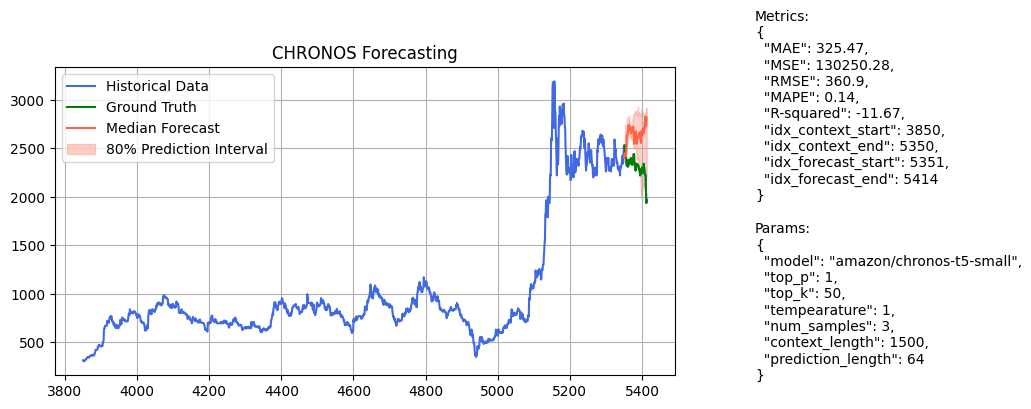

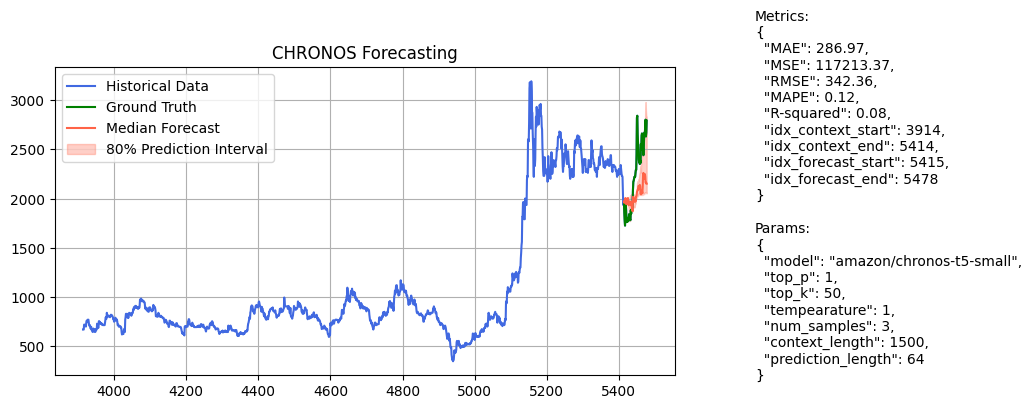

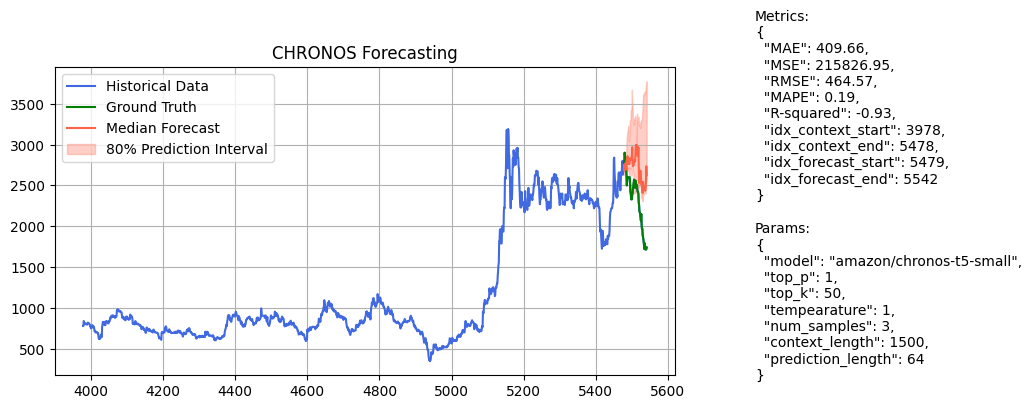

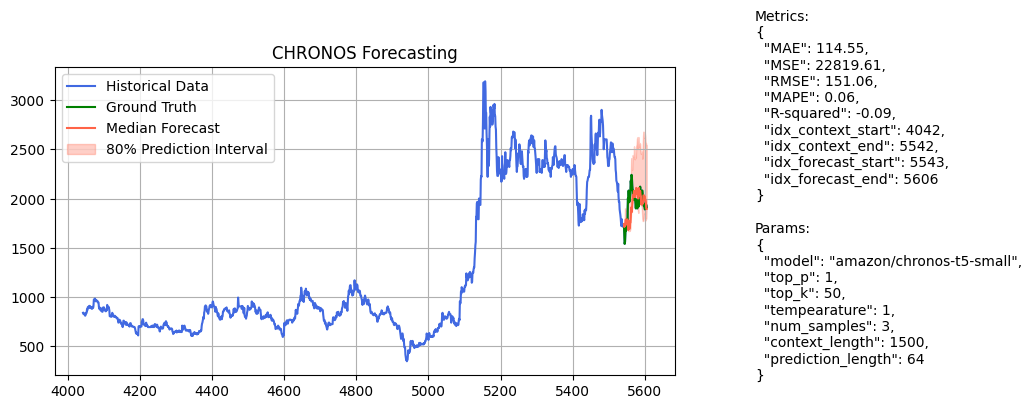

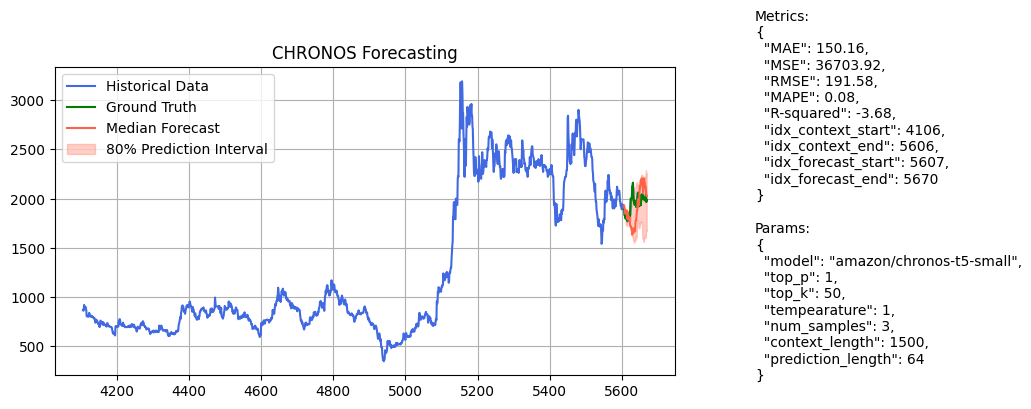

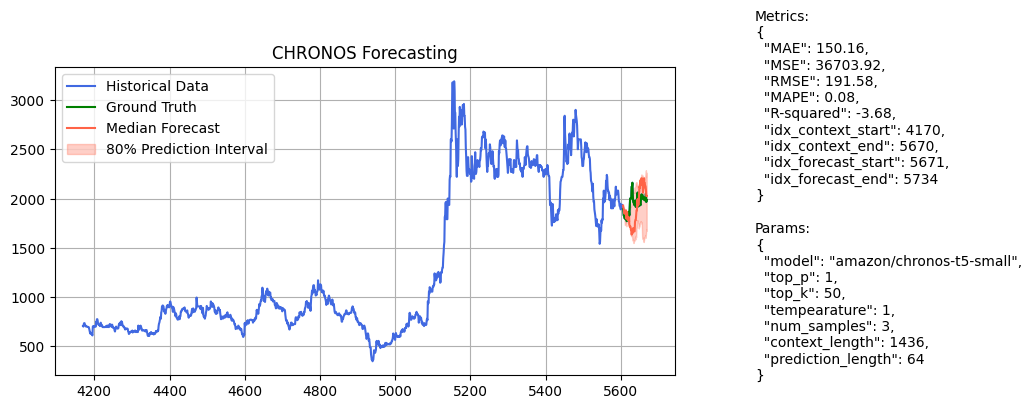

In [3]:
df = pd.read_csv('/home/yogi/chronos-research/dataset/LQ45-daily/ANTM.csv')

PRED_DURATION = 365 * 1 # A multiplier of 24 as I was working with hourly dataset
FORECAST_LEN = 64 # Trying to keep this less than 64 data points for best chronos performance
PRED_START = len(df) - PRED_DURATION # The index where to split context and test data from your df
CONTEXT_LEN = 1500 # Choose this wisely from above hyperparameter tuning experiment

agg_metrics = []
pred_indices = [i for i in range(len(df), PRED_START, -FORECAST_LEN)][::-1]


og_df = df.copy()
TARGET_COLUMN = 'close'

for idx in pred_indices:
    print(f'Running with idx = {idx}')
    fc = ChronosForecaster()
    
    df = og_df[(idx-CONTEXT_LEN):(idx+FORECAST_LEN)].copy()

    if idx > len(og_df):
        continue

    df.dropna(inplace=True)

    context, test = fc.split_train_test_by_sample_size(df, target_column=TARGET_COLUMN, test_sample_size=FORECAST_LEN)

    forecast, metrics, median = fc.predict( model_name="amazon/chronos-t5-small", num_samples=3)

    metrics['idx_context_start'] = idx - CONTEXT_LEN
    metrics['idx_context_end'] = idx
    metrics['idx_forecast_start'] = idx + 1
    metrics['idx_forecast_end'] = idx + FORECAST_LEN

    agg_metrics.append(metrics | json.loads(fc.params))

    fc.plot_forecast(df[TARGET_COLUMN])

In [5]:
#%%
import numpy as np
import pandas as pd
import torch
from gluonts.dataset.repository import get_dataset
from gluonts.dataset.split import split
from gluonts.ev.metrics import MASE, MeanWeightedSumQuantileLoss
from gluonts.itertools import batcher
from gluonts.model.evaluation import evaluate_forecasts
from gluonts.model.forecast import SampleForecast
from tqdm.auto import tqdm
from gluonts.dataset.common import ListDataset

from chronos import ChronosPipeline

# Load dataset
batch_size = 32
num_samples = 20
df = pd.read_csv('/home/yogi/chronos-research/dataset/daily-all/TLKM.csv')

# Ensure the date column is in datetime format and sort by date
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')

# Prepare ListDataset for GluonTS
prediction_length = 64
freq = "D"  # Daily frequency
# dataset = ListDataset(
#     [{"start": df['timestamp'].iloc[0], "target": df['close'].values}],  # Assuming 'close' is the target column
#     freq=freq
# )
dataset = [
    {
        "start": pd.Period(df['timestamp'].iloc[0], freq=freq),
        "target": df["close"].values
    }
]

# Load Chronos
pipeline = ChronosPipeline.from_pretrained(
    "/home/yogi/chronos-research/chronos-forecasting/scripts/output/run-6/checkpoint-300000",
    device_map="cuda:0",
    torch_dtype=torch.bfloat16,
)

# Split dataset for evaluation
train_data, test_data = split(dataset, offset=-prediction_length)
test_data = test_data.generate_instances(prediction_length)


# Generate forecast samples
forecast_samples = []
for batch in tqdm(batcher(test_data.input, batch_size=32)):
    context = [torch.tensor(entry["target"]) for entry in batch]
    forecast_samples.append(
        pipeline.predict(
            context,
            prediction_length=prediction_length,
            num_samples=num_samples,
        ).numpy()
    )
forecast_samples = np.concatenate(forecast_samples)

# Convert forecast samples into gluonts SampleForecast objects
sample_forecasts = []
for item, ts in zip(forecast_samples, test_data.input):
    forecast_start_date = ts["start"] + len(ts["target"])
    sample_forecasts.append(
        SampleForecast(samples=item, start_date=forecast_start_date)
    )

# Evaluate
metrics_df = evaluate_forecasts(
    sample_forecasts,
    test_data=test_data,
    metrics=[
        MASE(),
        MeanWeightedSumQuantileLoss(np.arange(0.1, 1.0, 0.1)),
    ],
)

metrics_df


0it [00:00, ?it/s]

Hasil mean scaling= tensor([[0.6936, 0.6989, 0.6910, 0.6910, 0.6910, 0.6910, 0.6752, 0.6804, 0.6804,
         0.7305, 0.7464, 0.7596, 0.7543, 0.8123, 0.8018, 0.7886, 0.8097, 0.8492,
         0.8387, 0.8360, 0.8492, 0.8756, 0.8835, 0.8650, 0.9152, 0.9125, 0.8519,
         0.8545, 0.8782, 0.8703, 0.8571, 0.8782, 0.8703, 0.8703, 0.8598, 0.8650,
         0.8756, 0.9099, 0.9521, 0.9336, 0.9257, 0.9283, 0.8861, 0.8756, 0.8756,
         0.8756, 0.9046, 0.9020, 0.8730, 0.8730, 0.8730, 0.9204, 0.9152, 0.8888,
         0.8941, 0.9415, 0.9494, 0.9257, 0.9178, 0.9231, 0.9178, 0.9099, 0.8993,
         0.9152, 0.9178, 0.8941, 0.8888, 0.8598, 0.8914, 0.8545, 0.8202, 0.8519,
         0.8624, 0.8545, 0.8677, 0.8677, 0.8650, 0.8439, 0.8413, 0.8413, 0.8413,
         0.8492, 0.8466, 0.8308, 0.8387, 0.8466, 0.8360, 0.9152, 0.9178, 0.9204,
         0.9204, 0.9204, 0.9125, 0.9072, 0.8861, 0.8756, 0.8809, 0.8677, 0.8967,
         0.8967, 0.9099, 0.8914, 0.8861, 0.8941, 0.9099, 0.9072, 0.8914, 0.8861,
        

1it [00:00,  1.93it/s]


token=  tensor([[2191],
        [2191],
        [2195],
        [2197],
        [2196],
        [2189],
        [2188],
        [2191],
        [2190],
        [2190],
        [2187],
        [2197],
        [2190],
        [2188],
        [2187],
        [2191],
        [2189],
        [2189],
        [2214],
        [2190]], device='cuda:0')
Ukuran Tabel Embedding: Embedding(4096, 512)
inputs_embeds=  tensor([[[-0.1318,  0.5469,  0.6914,  ..., -0.5234, -0.1484,  0.3535]],

        [[-0.1318,  0.5469,  0.6914,  ..., -0.5234, -0.1484,  0.3535]],

        [[-0.3633,  0.5430, -0.4375,  ..., -0.0208,  0.4512,  0.3711]],

        ...,

        [[-0.0413,  0.6484,  0.2285,  ..., -0.1157, -0.1250,  0.3066]],

        [[ 0.0066,  0.7070, -0.0209,  ...,  0.5195,  0.4180,  0.3574]],

        [[-0.3125,  0.1543,  0.1260,  ..., -0.4805,  0.0493,  0.3359]]],
       device='cuda:0', dtype=torch.bfloat16)
testt1
torch.Size([20, 1])
testt2
batch_size=  20
seq_length=  1
token=  tensor([[2190],
      

1it [00:00, 248.04it/s]


,MASE[0.5],mean_weighted_sum_quantile_loss
None,4.990018,0.027283


In [4]:
#%%
import numpy as np
import pandas as pd
import torch
from gluonts.dataset.repository import get_dataset
from gluonts.dataset.split import split
from gluonts.ev.metrics import MASE, MeanWeightedSumQuantileLoss
from gluonts.itertools import batcher
from gluonts.model.evaluation import evaluate_forecasts
from gluonts.model.forecast import SampleForecast
from tqdm.auto import tqdm
from gluonts.dataset.common import ListDataset

from chronos import ChronosPipeline

# Load dataset
batch_size = 32
num_samples = 20
df = pd.read_csv('/home/yogi/chronos-research/dataset/daily-all/ANTM.csv')

# Hitung jumlah total baris
# total_rows = len(df)

# Hitung jumlah baris yang mencakup 30% terakhir
# rows_to_take = int(0.3 * total_rows)

# # Ambil 30% baris terakhir
# df = df.tail(rows_to_take)

# # Hitung 70% dari total baris
# rows_to_take = int(0.7 * total_rows)

# # Ambil 70% pertama dari data
# df = df.head(rows_to_take)

# Ensure the date column is in datetime format and sort by date
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')

# Prepare ListDataset for GluonTS
prediction_length = 64
freq = "D"  # Daily frequency
# dataset = ListDataset(
#     [{"start": df['timestamp'].iloc[0], "target": df['close'].values}],  # Assuming 'close' is the target column
#     freq=freq
# )
dataset = [
    {
        "start": pd.Period(df['timestamp'].iloc[0], freq=freq),
        "target": df["close"].values
    }
]

# Load Chronos
pipeline = ChronosPipeline.from_pretrained(
    "/home/yogi/chronos-research/chronos-forecasting/scripts/output/run-4/checkpoint-100000",
    device_map="cuda:1",
    torch_dtype=torch.bfloat16,
)

# Split dataset for evaluation
train_data, test_data = split(dataset, offset=-prediction_length)
test_data = test_data.generate_instances(prediction_length)


# Generate forecast samples
forecast_samples = []
for batch in tqdm(batcher(test_data.input, batch_size=32)):
    context = [torch.tensor(entry["target"]) for entry in batch]
    forecast_samples.append(
        pipeline.predict(
            context,
            prediction_length=prediction_length,
            num_samples=num_samples,
        ).numpy()
    )
forecast_samples = np.concatenate(forecast_samples)

# Convert forecast samples into gluonts SampleForecast objects
sample_forecasts = []
for item, ts in zip(forecast_samples, test_data.input):
    forecast_start_date = ts["start"] + len(ts["target"])
    sample_forecasts.append(
        SampleForecast(samples=item, start_date=forecast_start_date)
    )

# Evaluate
metrics_df = evaluate_forecasts(
    sample_forecasts,
    test_data=test_data,
    metrics=[
        MASE(),
        MeanWeightedSumQuantileLoss(np.arange(0.1, 1.0, 0.1)),
    ],
)

metrics_df


0it [00:00, ?it/s]

token=  tensor([[2115, 2114, 2114, 2114, 2114, 2114, 2116, 2117, 2117, 2118, 2118, 2125,
         2122, 2122, 2121, 2121, 2122, 2122, 2125, 2125, 2123, 2126, 2125, 2123,
         2123, 2124, 2119, 2120, 2125, 2126, 2125, 2127, 2129, 2129, 2134, 2138,
         2142, 2144, 2160, 2160, 2168, 2169, 2161, 2159, 2159, 2159, 2171, 2168,
         2167, 2167, 2167, 2183, 2186, 2185, 2208, 2208, 2207, 2219, 2240, 2244,
         2240, 2227, 2215, 2244, 2238, 2225, 2225, 2212, 2205, 2195, 2185, 2208,
         2197, 2192, 2196, 2212, 2222, 2216, 2228, 2225, 2225, 2227, 2225, 2217,
         2219, 2225, 2230, 2229, 2227, 2230, 2223, 2223, 2216, 2214, 2203, 2197,
         2189, 2186, 2186, 2186, 2197, 2192, 2188, 2190, 2189, 2187, 2187, 2188,
         2182, 2182, 2198, 2187, 2184, 2187, 2186, 2186, 2184, 2192, 2193, 2200,
         2192, 2187, 2188, 2192, 2191, 2195, 2192, 2193, 2194, 2193, 2191, 2195,
         2195, 2198, 2203, 2201, 2203, 2209, 2210, 2209, 2209, 2213, 2212, 2212,
         2212, 2212,

1it [00:01,  1.67s/it]


token=  tensor([[2153],
        [2165],
        [2159],
        [2159],
        [2167],
        [2168],
        [2160],
        [2141],
        [2143],
        [2169],
        [2160],
        [2151],
        [2165],
        [2137],
        [2142],
        [2169],
        [2165],
        [2136],
        [2140],
        [2169]], device='cuda:1')
Ukuran Tabel Embedding: Embedding(4096, 512)
inputs_embeds=  tensor([[[ 1.3906, -1.4297,  0.6602,  ...,  0.1836,  0.8008,  0.6133]],

        [[ 0.4980, -0.7891, -0.0320,  ..., -0.2070,  0.1523,  0.5547]],

        [[ 0.1357,  0.7500, -0.0928,  ...,  1.4453, -0.3301,  0.4160]],

        ...,

        [[ 0.2871,  0.7617, -0.3848,  ...,  0.3164, -0.8594,  0.5391]],

        [[ 0.8672,  0.6367, -0.8281,  ...,  0.2812, -0.8516,  0.5547]],

        [[ 0.4453,  0.1533, -0.6133,  ..., -0.9219,  0.3730,  0.5078]]],
       device='cuda:1', dtype=torch.bfloat16)
testt1
torch.Size([20, 1])
testt2
batch_size=  20
seq_length=  1


1it [00:00, 244.89it/s]


,MASE[0.5],mean_weighted_sum_quantile_loss
None,4.910444,0.048781


In [1]:
#%%
import numpy as np
import pandas as pd
import torch
from gluonts.dataset.repository import get_dataset
from gluonts.dataset.split import split
from gluonts.ev.metrics import MASE, MeanWeightedSumQuantileLoss
from gluonts.itertools import batcher
from gluonts.model.evaluation import evaluate_forecasts
from gluonts.model.forecast import SampleForecast
from tqdm.auto import tqdm
from gluonts.dataset.common import ListDataset

from chronos import ChronosPipeline

# Load dataset
batch_size = 32
num_samples = 20
df = pd.read_csv('/home/yogi/chronos-research/dataset/daily-all/TLKM.csv')

# # Hitung jumlah total baris
# total_rows = len(df)

# # Hitung 70% dari total baris
# rows_to_take = int(0.7 * total_rows)

# # Ambil 70% pertama dari data
# df = df.head(rows_to_take)

# Ensure the date column is in datetime format and sort by date
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')

# Prepare ListDataset for GluonTS
prediction_length = 64
freq = "D"  # Daily frequency
# dataset = ListDataset(
#     [{"start": df['timestamp'].iloc[0], "target": df['close'].values}],  # Assuming 'close' is the target column
#     freq=freq
# )
dataset = [
    {
        "start": pd.Period(df['timestamp'].iloc[0], freq=freq),
        "target": df["close"].values
    }
]

# Load Chronos
pipeline = ChronosPipeline.from_pretrained(
    "/home/yogi/chronos-research/chronos-forecasting/scripts/output/42-dataset/checkpoint-final",
    device_map="cuda:1",
    torch_dtype=torch.bfloat16,
)

# Split dataset for evaluation
train_data, test_data = split(dataset, offset=-prediction_length)
test_data = test_data.generate_instances(prediction_length)


# Generate forecast samples
forecast_samples = []
for batch in tqdm(batcher(test_data.input, batch_size=32)):
    context = [torch.tensor(entry["target"]) for entry in batch]
    forecast_samples.append(
        pipeline.predict(
            context,
            prediction_length=prediction_length,
            num_samples=num_samples,
        ).numpy()
    )
forecast_samples = np.concatenate(forecast_samples)

# Convert forecast samples into gluonts SampleForecast objects
sample_forecasts = []
for item, ts in zip(forecast_samples, test_data.input):
    forecast_start_date = ts["start"] + len(ts["target"])
    sample_forecasts.append(
        SampleForecast(samples=item, start_date=forecast_start_date)
    )

# Evaluate
metrics_df = evaluate_forecasts(
    sample_forecasts,
    test_data=test_data,
    metrics=[
        MASE(),
        MeanWeightedSumQuantileLoss(np.arange(0.1, 1.0, 0.1)),
    ],
)

metrics_df


/home/yogi/miniconda3/envs/chronos-zero-shot/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
0it [00:00, ?it/s]

token=  tensor([[2144, 2144, 2143, 2143, 2143, 2143, 2141, 2142, 2142, 2149, 2151, 2153,
         2152, 2160, 2158, 2157, 2159, 2165, 2163, 2163, 2165, 2168, 2170, 2167,
         2174, 2173, 2165, 2166, 2169, 2168, 2166, 2169, 2168, 2168, 2166, 2167,
         2168, 2173, 2179, 2176, 2175, 2176, 2170, 2168, 2168, 2168, 2172, 2172,
         2168, 2168, 2168, 2175, 2174, 2170, 2171, 2177, 2179, 2175, 2174, 2175,
         2174, 2173, 2172, 2174, 2174, 2171, 2170, 2166, 2171, 2166, 2161, 2165,
         2167, 2166, 2167, 2167, 2167, 2164, 2164, 2164, 2164, 2165, 2164, 2162,
         2163, 2164, 2163, 2174, 2174, 2175, 2175, 2175, 2173, 2173, 2170, 2168,
         2169, 2167, 2171, 2171, 2173, 2171, 2170, 2171, 2173, 2173, 2171, 2170,
         2170, 2172, 2175, 2172, 2171, 2172, 2171, 2171, 2171, 2170, 2171, 2171,
         2170, 2168, 2169, 2169, 2170, 2170, 2169, 2168, 2167, 2169, 2168, 2166,
         2163, 2162, 2164, 2164, 2163, 2164, 2164, 2164, 2164, 2163, 2163, 2163,
         2163, 2163,

2024-11-13 06:52:12.290606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 06:52:12.319003: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 06:52:12.347377: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 06:52:12.481310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-13 06:52:18.953180: W tensorflow/compiler/tf2

token=  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:1')
Ukuran Tabel Embedding: Embedding(4096, 512)
inputs_embeds=  tensor([[[ 0.1484,  0.0210, -0.0693,  ..., -0.3477,  0.0432,  3.0156]],

        [[ 0.1484,  0.0210, -0.0693,  ..., -0.3477,  0.0432,  3.0156]],

        [[ 0.1484,  0.0210, -0.0693,  ..., -0.3477,  0.0432,  3.0156]],

        ...,

        [[ 0.1484,  0.0210, -0.0693,  ..., -0.3477,  0.0432,  3.0156]],

        [[ 0.1484,  0.0210, -0.0693,  ..., -0.3477,  0.0432,  3.0156]],

        [[ 0.1484,  0.0210, -0.0693,  ..., -0.3477,  0.0432,  3.0156]]],
       device='cuda:1', dtype=torch.bfloat16)
testt1
torch.Size([20, 1])
testt2
batch_size=  20
seq_length=  1
token=  tensor([[2211],
        [2210],
        [2212],
        [2203],
        [2211],
  

1it [00:25, 25.83s/it]


tensor([[2219],
        [2215],
        [2195],
        [2200],
        [2194],
        [2215],
        [2190],
        [2195],
        [2194],
        [2199],
        [2194],
        [2207],
        [2192],
        [2193],
        [2209],
        [2199],
        [2209],
        [2194],
        [2186],
        [2194]], device='cuda:1')
Ukuran Tabel Embedding: Embedding(4096, 512)
inputs_embeds=  tensor([[[-0.6523,  0.3340,  1.1875,  ..., -0.2852,  0.5391,  0.0119]],

        [[ 0.1963,  0.9883,  0.6602,  ...,  1.2422,  0.9922,  0.4297]],

        [[-0.3652,  0.4727, -0.4941,  ...,  0.0723,  0.5508,  0.2695]],

        ...,

        [[-0.2793,  0.2441,  0.0811,  ..., -0.6289,  0.7695,  0.5859]],

        [[ 0.1025,  0.5859, -0.1699,  ...,  0.9375, -0.0811,  0.6289]],

        [[-0.2793,  0.2441,  0.0811,  ..., -0.6289,  0.7695,  0.5859]]],
       device='cuda:1', dtype=torch.bfloat16)
testt1
torch.Size([20, 1])
testt2
batch_size=  20
seq_length=  1
token=  tensor([[2217],
        [2225]

1it [00:00, 26.25it/s]


,MASE[0.5],mean_weighted_sum_quantile_loss
None,10.348085,0.053441


In [ ]:
%load_ext tensorboard
# %tensorboard --logdir=/home/yogi/chronos-research/chronos-forecasting/scripts/output/42-dataset/logs


In [5]:
from datasets import Dataset
import pandas as pd
import datasets
from sklearn.model_selection import train_test_split

file_path = f"/home/yogi/chronos-research/dataset/daily-all/ANTM.csv"

df = pd.read_csv(file_path)
df = pd.DataFrame(df)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')
data = Dataset.from_pandas(df).train_test_split(test_size=0.2)

train_ds=Dataset.from_pandas(pd.DataFrame(data['train']).sort_values(by='timestamp'))
test_ds=Dataset.from_pandas(pd.DataFrame(data['test']).sort_values(by='timestamp'))

combined_data = {}

# Iterate through the columns of train and test, and combine them
for column in data['train'].column_names:
    combined_data[column] = [train_ds[column], test_ds[column]]

# Create the combined dataset
combined_dataset = Dataset.from_dict(combined_data)

# combined_data['timestamp'][0][len(data['train']-1)]
combined_data['timestamp'][0][len(data['train'])-1]
combined_data['close'][1]
data['train']['timestamp']


[Timestamp('2016-06-20 00:00:00'),
 Timestamp('2006-08-03 00:00:00'),
 Timestamp('2019-02-14 00:00:00'),
 Timestamp('2006-10-27 00:00:00'),
 Timestamp('2018-07-24 00:00:00'),
 Timestamp('2009-11-12 00:00:00'),
 Timestamp('2020-08-13 00:00:00'),
 Timestamp('2012-02-20 00:00:00'),
 Timestamp('2010-05-05 00:00:00'),
 Timestamp('2008-05-21 00:00:00'),
 Timestamp('2004-01-15 00:00:00'),
 Timestamp('2021-11-19 00:00:00'),
 Timestamp('2018-05-03 00:00:00'),
 Timestamp('2016-07-28 00:00:00'),
 Timestamp('2021-01-11 00:00:00'),
 Timestamp('2002-12-24 00:00:00'),
 Timestamp('2022-05-31 00:00:00'),
 Timestamp('2001-06-18 00:00:00'),
 Timestamp('2018-08-21 00:00:00'),
 Timestamp('2012-08-14 00:00:00'),
 Timestamp('2008-04-11 00:00:00'),
 Timestamp('2001-08-31 00:00:00'),
 Timestamp('2022-08-08 00:00:00'),
 Timestamp('2016-01-05 00:00:00'),
 Timestamp('2006-05-08 00:00:00'),
 Timestamp('2021-01-18 00:00:00'),
 Timestamp('2018-03-20 00:00:00'),
 Timestamp('2004-12-30 00:00:00'),
 Timestamp('2003-02-

In [51]:
combined_dataset[0]['timestamp']

array(['2001-04-16T00:00:00.000000', '2001-04-17T00:00:00.000000',
       '2001-04-18T00:00:00.000000', ..., '2023-01-02T00:00:00.000000',
       '2023-01-04T00:00:00.000000', '2023-01-06T00:00:00.000000'],
      dtype='datetime64[us]')

In [ ]:
combined_dataset.set_format("numpy")
series_fields = [
    col
    for col in combined_dataset.features
    if isinstance(combined_dataset.features[col], datasets.Sequence)
]
series_fields.remove("timestamp")
dataset_freq = "D"

gts_dataset = []
for hf_entry in combined_dataset:
    print("hf_entry=", hf_entry)
    for field in series_fields:
        print("field=", field)
        gts_dataset.append(
            {
                "start": pd.Period(
                    hf_entry["timestamp"][0],
                    freq=dataset_freq,
                ),
                "target": hf_entry[field],
            }
        )
# assert len(gts_dataset) == dataset_length

gts_dataset

hf_entry= {'timestamp': array(['2001-04-18T00:00:00.000000', '2001-04-19T00:00:00.000000',
       '2001-04-23T00:00:00.000000', ..., '2023-01-03T00:00:00.000000',
       '2023-01-04T00:00:00.000000', '2023-01-06T00:00:00.000000'],
      dtype='datetime64[us]'), 'close': array([ 432,  432,  432, ..., 2000, 2050, 1985])}
field= close
hf_entry= {'timestamp': array(['2001-04-16T00:00:00.000000', '2001-04-17T00:00:00.000000',
       '2001-04-20T00:00:00.000000', ..., '2022-12-28T00:00:00.000000',
       '2022-12-30T00:00:00.000000', '2023-01-05T00:00:00.000000'],
      dtype='datetime64[us]'), 'close': array([ 432,  432,  432, ..., 2010, 1985, 1965])}
field= close


[{'start': Period('2001-04-18', 'D'),
  'target': array([ 432,  432,  432, ..., 2000, 2050, 1985])},
 {'start': Period('2001-04-16', 'D'),
  'target': array([ 432,  432,  432, ..., 2010, 1985, 1965])}]

In [37]:

train_df, remaining_df = train_test_split(gts_dataset, train_size=0.7, random_state=42)
print(len(remaining_df))  # Untuk mengecek panjang remaining_df

# valid_df, test_df = train_test_split(remaining_df, test_size=0.2 / (0.1 + 0.2), random_state=42)

1


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
import datasets

# Membaca file CSV
file_path = "/home/yogi/chronos-research/dataset/daily-all/ANTM.csv"  # Ganti dengan path file CSV Anda
df = pd.read_csv(file_path, parse_dates=['timestamp'])

# Membagi data menjadi train dan test (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

# Menyimpan data train dan test ke dalam file CSV baru
train_df.to_csv('/home/yogi/chronos-research/Retrieval-Augmented-Time-Series-Forecasting/temp/train.csv', index=False)
test_df.to_csv('/home/yogi/chronos-research/Retrieval-Augmented-Time-Series-Forecasting/temp/test.csv', index=False)

data_files = {'train': '/home/yogi/chronos-research/Retrieval-Augmented-Time-Series-Forecasting/temp/train.csv', 
              'test': '/home/yogi/chronos-research/Retrieval-Augmented-Time-Series-Forecasting/temp/test.csv'}
ds = datasets.load_dataset('csv', data_files=data_files, split="train")

ds

Generating train split: 4536 examples [00:00, 833166.76 examples/s]
Generating test split: 1134 examples [00:00, 555777.14 examples/s]


Dataset({
    features: ['timestamp', 'open', 'low', 'high', 'close', 'volume'],
    num_rows: 4536
})

In [24]:
ds = datasets.load_dataset("autogluon/chronos_datasets_extra", "ETTh", split="train", trust_remote_code=True)
ds

Dataset({
    features: ['id', 'timestamp', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'],
    num_rows: 2
})

In [26]:
ds['HUFL'][0]

[5.827000141143799,
 5.692999839782715,
 5.1570000648498535,
 5.090000152587892,
 5.357999801635742,
 5.625999927520752,
 7.166999816894531,
 7.434999942779541,
 5.559000015258789,
 4.554999828338623,
 4.956999778747559,
 5.760000228881836,
 4.689000129699707,
 4.689000129699707,
 5.090000152587892,
 5.090000152587892,
 4.2199997901916495,
 4.75600004196167,
 5.625999927520752,
 5.492000102996826,
 5.357999801635742,
 5.090000152587892,
 4.822999954223633,
 4.622000217437744,
 5.223999977111816,
 5.1570000648498535,
 5.1570000648498535,
 5.1570000648498535,
 4.554999828338623,
 5.425000190734863,
 5.492000102996826,
 5.625999927520752,
 5.559000015258789,
 5.223999977111816,
 9.913000106811523,
 11.788000106811523,
 9.645000457763672,
 10.381999969482422,
 8.77400016784668,
 10.449000358581545,
 9.845999717712402,
 9.913000106811523,
 10.649999618530272,
 10.11400032043457,
 9.979999542236328,
 9.3100004196167,
 9.444000244140623,
 9.444000244140623,
 10.381999969482422,
 9.77900028228

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
import numpy as np
from gluonts.dataset.split import split

df = pd.read_csv("/home/yogi/chronos-research/dataset/daily-all/ANTM.csv")

# Pastikan kolom 'timestamp' ada dan dikonversi ke datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Mengurutkan berdasarkan timestamp
df = df.sort_values(by='timestamp')

series_fields = [col for col in df.columns if col != 'timestamp']
    
# Menentukan frekuensi data (harus sudah teratur dengan interval yang konsisten)
dataset_freq = "D"

gts_dataset = []
for _, row in df.iterrows():
    for field in series_fields:
        gts_dataset.append(
            {
                "start": pd.Period(row["timestamp"], freq=dataset_freq),
                "target": row[field],
            }
        )

# Split data menjadi train, validation, dan test
train_df, remaining_df = train_test_split(gts_dataset, train_size=0.7, random_state=42)
valid_df, test_df = train_test_split(remaining_df, test_size=0.2 / (0.1 + 0.2), random_state=42)

# Split dataset untuk evaluasi
_, test_template = split(test_df, offset=-60)
test_data = test_template.generate_instances(60, windows=2, distance=20, max_history=75)


In [15]:
train_df

[{'start': Period('2005-12-29', 'D'), 'target': 46965580},
 {'start': Period('2001-12-05', 'D'), 'target': 432},
 {'start': Period('2015-01-26', 'D'), 'target': 894},
 {'start': Period('2006-04-14', 'D'), 'target': 0},
 {'start': Period('2016-07-19', 'D'), 'target': 820},
 {'start': Period('2019-09-05', 'D'), 'target': 1115},
 {'start': Period('2001-08-09', 'D'), 'target': 432},
 {'start': Period('2020-12-29', 'D'), 'target': 2050},
 {'start': Period('2006-07-21', 'D'), 'target': 17580841},
 {'start': Period('2014-11-05', 'D'), 'target': 785},
 {'start': Period('2015-06-30', 'D'), 'target': 4997994},
 {'start': Period('2016-05-23', 'D'), 'target': 650},
 {'start': Period('2014-06-19', 'D'), 'target': 957},
 {'start': Period('2009-08-24', 'D'), 'target': 2141},
 {'start': Period('2021-12-30', 'D'), 'target': 2250},
 {'start': Period('2007-02-27', 'D'), 'target': 1553},
 {'start': Period('2021-02-23', 'D'), 'target': 2920},
 {'start': Period('2002-05-21', 'D'), 'target': 436},
 {'start':

In [27]:
import datasets

offset_alias_to_period_alias = {
    "WEEKDAY": "D",
    "EOM": "M",
    "BME": "M",
    "SME": "M",
    "BQS": "Q",
    "QS": "Q",
    "BQE": "Q",
    "BQE-DEC": "Q",
    "BQE-JAN": "Q",
    "BQE-FEB": "Q",
    "BQE-MAR": "Q",
    "BQE-APR": "Q",
    "BQE-MAY": "Q",
    "BQE-JUN": "Q",
    "BQE-JUL": "Q",
    "BQE-AUG": "Q",
    "BQE-SEP": "Q",
    "BQE-OCT": "Q",
    "BQE-NOV": "Q",
    "MS": "M",
    "D": "D",
    "B": "B",
    "min": "min",
    "s": "s",
    "ms": "ms",
    "us": "us",
    "ns": "ns",
    "h": "h",
    "QE": "Q",
    "QE-DEC": "Q-DEC",
    "QE-JAN": "Q-JAN",
    "QE-FEB": "Q-FEB",
    "QE-MAR": "Q-MAR",
    "QE-APR": "Q-APR",
    "QE-MAY": "Q-MAY",
    "QE-JUN": "Q-JUN",
    "QE-JUL": "Q-JUL",
    "QE-AUG": "Q-AUG",
    "QE-SEP": "Q-SEP",
    "QE-OCT": "Q-OCT",
    "QE-NOV": "Q-NOV",
    "YE": "Y",
    "YE-DEC": "Y-DEC",
    "YE-JAN": "Y-JAN",
    "YE-FEB": "Y-FEB",
    "YE-MAR": "Y-MAR",
    "YE-APR": "Y-APR",
    "YE-MAY": "Y-MAY",
    "YE-JUN": "Y-JUN",
    "YE-JUL": "Y-JUL",
    "YE-AUG": "Y-AUG",
    "YE-SEP": "Y-SEP",
    "YE-OCT": "Y-OCT",
    "YE-NOV": "Y-NOV",
    "W": "W",
    "ME": "M",
    "Y": "Y",
    "BYE": "Y",
    "BYE-DEC": "Y",
    "BYE-JAN": "Y",
    "BYE-FEB": "Y",
    "BYE-MAR": "Y",
    "BYE-APR": "Y",
    "BYE-MAY": "Y",
    "BYE-JUN": "Y",
    "BYE-JUL": "Y",
    "BYE-AUG": "Y",
    "BYE-SEP": "Y",
    "BYE-OCT": "Y",
    "BYE-NOV": "Y",
    "YS": "Y",
    "BYS": "Y",
    "QS-JAN": "Q",
    "QS-FEB": "Q",
    "QS-MAR": "Q",
    "QS-APR": "Q",
    "QS-MAY": "Q",
    "QS-JUN": "Q",
    "QS-JUL": "Q",
    "QS-AUG": "Q",
    "QS-SEP": "Q",
    "QS-OCT": "Q",
    "QS-NOV": "Q",
    "QS-DEC": "Q",
    "BQS-JAN": "Q",
    "BQS-FEB": "Q",
    "BQS-MAR": "Q",
    "BQS-APR": "Q",
    "BQS-MAY": "Q",
    "BQS-JUN": "Q",
    "BQS-JUL": "Q",
    "BQS-AUG": "Q",
    "BQS-SEP": "Q",
    "BQS-OCT": "Q",
    "BQS-NOV": "Q",
    "BQS-DEC": "Q",
    "YS-JAN": "Y",
    "YS-FEB": "Y",
    "YS-MAR": "Y",
    "YS-APR": "Y",
    "YS-MAY": "Y",
    "YS-JUN": "Y",
    "YS-JUL": "Y",
    "YS-AUG": "Y",
    "YS-SEP": "Y",
    "YS-OCT": "Y",
    "YS-NOV": "Y",
    "YS-DEC": "Y",
    "BYS-JAN": "Y",
    "BYS-FEB": "Y",
    "BYS-MAR": "Y",
    "BYS-APR": "Y",
    "BYS-MAY": "Y",
    "BYS-JUN": "Y",
    "BYS-JUL": "Y",
    "BYS-AUG": "Y",
    "BYS-SEP": "Y",
    "BYS-OCT": "Y",
    "BYS-NOV": "Y",
    "BYS-DEC": "Y",
    "Y-JAN": "Y-JAN",
    "Y-FEB": "Y-FEB",
    "Y-MAR": "Y-MAR",
    "Y-APR": "Y-APR",
    "Y-MAY": "Y-MAY",
    "Y-JUN": "Y-JUN",
    "Y-JUL": "Y-JUL",
    "Y-AUG": "Y-AUG",
    "Y-SEP": "Y-SEP",
    "Y-OCT": "Y-OCT",
    "Y-NOV": "Y-NOV",
    "Y-DEC": "Y-DEC",
    "Q-JAN": "Q-JAN",
    "Q-FEB": "Q-FEB",
    "Q-MAR": "Q-MAR",
    "Q-APR": "Q-APR",
    "Q-MAY": "Q-MAY",
    "Q-JUN": "Q-JUN",
    "Q-JUL": "Q-JUL",
    "Q-AUG": "Q-AUG",
    "Q-SEP": "Q-SEP",
    "Q-OCT": "Q-OCT",
    "Q-NOV": "Q-NOV",
    "Q-DEC": "Q-DEC",
    "W-MON": "W-MON",
    "W-TUE": "W-TUE",
    "W-WED": "W-WED",
    "W-THU": "W-THU",
    "W-FRI": "W-FRI",
    "W-SAT": "W-SAT",
    "W-SUN": "W-SUN",
}

ds = datasets.load_dataset(
    "autogluon/chronos_datasets_extra", "ETTh", split="train", trust_remote_code=True
)
ds.set_format("numpy")

series_fields = [
    col
    for col in ds.features
    if isinstance(ds.features[col], datasets.Sequence)
]
series_fields.remove("timestamp")
dataset_length = ds.info.splits["train"].num_examples * len(series_fields)
dataset_freq = pd.infer_freq(ds[0]["timestamp"])
dataset_freq = offset_alias_to_period_alias.get(dataset_freq, dataset_freq)


gts_dataset = []
for hf_entry in ds:
    for field in series_fields:
        gts_dataset.append(
            {
                "start": pd.Period(
                    hf_entry["timestamp"][0],
                    freq=dataset_freq,
                ),
                "target": hf_entry[field],
            }
        )

train_df, remaining_df = train_test_split(gts_dataset, train_size=0.7, random_state=42)
valid_df, test_df = train_test_split(remaining_df, test_size=0.2 / (0.1 + 0.2), random_state=42)

# Split dataset for evaluation
_, test_template = split(test_df, offset=-60)
test_data = test_template.generate_instances(60, windows=2, distance=20, max_history=75)

In [28]:
train_df

[{'start': Period('2016-07-01 00:00', 'h'),
  'target': array([12.481, 10.136, 11.309, ..., 10.974, 13.403, 10.052], dtype=float32)},
 {'start': Period('2016-07-01 00:00', 'h'),
  'target': array([ 1.599,  1.492,  1.279, ..., -0.817,  5.472,  6.183], dtype=float32)},
 {'start': Period('2016-07-01 00:00', 'h'),
  'target': array([2.009, 2.076, 1.741, ..., 3.818, 3.818, 3.55 ], dtype=float32)},
 {'start': Period('2016-07-01 00:00', 'h'),
  'target': array([38.662 , 37.124 , 36.465 , ..., 48.1835, 46.8655, 45.9865],
        dtype=float32)},
 {'start': Period('2016-07-01 00:00', 'h'),
  'target': array([4.203, 4.142, 3.777, ..., 3.716, 3.655, 3.716], dtype=float32)},
 {'start': Period('2016-07-01 00:00', 'h'),
  'target': array([41.13 , 37.528, 37.947, ..., 39.622, 43.643, 38.868], dtype=float32)},
 {'start': Period('2016-07-01 00:00', 'h'),
  'target': array([ 9.355,  7.532,  9.007, ..., 11.661, 13.778, 10.669], dtype=float32)},
 {'start': Period('2016-07-01 00:00', 'h'),
  'target': arra

In [29]:
df = pd.read_csv("/home/yogi/chronos-research/dataset/daily-all/ANTM.csv")

# Ensure the date column is in datetime format and sort by date
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')

# Prepare ListDataset for GluonTS
prediction_length = 50
freq = "D"  # Daily frequency
dataset = [
{
    "start": pd.Period(df['timestamp'].iloc[0], freq=freq),
    "target": df["close"].values
}
]

# Split dataset for evaluation
train_data, test_data = split(dataset, offset=-prediction_length)
test_data = test_data.generate_instances(prediction_length)
train_data

TrainingDataset(dataset=[{'start': Period('2001-04-16', 'D'), 'target': array([ 432,  432,  432, ..., 2050, 1965, 1985])}], splitter=OffsetSplitter(offset=-50))

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
import datasets

dataset_name=["AALI","ABBA","ABDA","ABMM","ACES","ACST","ADCP","ADES","ADHI","ADMF","ADMG","ADMR","ADRO","AGAR","AGII","AGRO","AGRS","AHAP","AIMS","AISA","AKKU","AKPI","AKRA","AKSI","ALDO","ALKA","ALMI","ALTO","AMAG","AMAN","AMAR","AMFG","AMIN","AMMS","AMOR","AMRT","ANDI","ANJT","ANTM","APEX","APIC","APII","APLI","APLN","ARCI","ARGO","ARII","ARKA","ARKO","ARMY","ARNA","ARTA","ARTI","ARTO","ASBI","ASDM","ASGR","ASHA","ASJT","ASLC","ASMI","ASPI","ASRI","ASRM","ASSA","ATAP","ATIC","AUTO","AVIA","AXIO","AYLS","BABP","BACA","BAJA","BALI","BANK","BAPA","BAPI","BATA","BAUT","BAYU","BBCA","BBHI","BBKP","BBLD","BBMD","BBNI","BBRI","BBRM","BBSI","BBSS","BBTN","BBYB","BCAP","BCIC","BCIP","BDMN","BEBS","BEEF","BEKS","BELI","BELL","BESS","BEST","BFIN","BGTG","BHAT","BHIT","BIKA","BIKE","BIMA","BINA","BINO","BIPI","BIPP","BIRD","BISI","BJBR","BJTM","BKDP","BKSL","BKSW","BLTA","BLTZ","BLUE","BMAS","BMHS","BMRI","BMSR","BMTR","BNBA","BNBR","BNGA","BNII","BNLI","BOBA","BOGA","BOLA","BOLT","BOSS","BPFI","BPII","BPTR","BRAM","BRIS","BRMS","BRNA","BRPT","BSBK","BSDE","BSIM","BSML","BSSR","BSWD","BTEK","BTEL","BTON","BTPN","BTPS","BUAH","BUDI","BUKA","BUKK","BULL","BUMI","BUVA","BVIC","BWPT","BYAN","CAKK","CAMP","CANI","CARE","CARS","CASA","CASH","CASS","CBMF","CBUT","CCSI","CEKA","CENT","CFIN","CHEM","CINT","CITA","CITY","CLAY","CLEO","CLPI","CMNP","CMNT","CMPP","CMRY","CNKO","CNTX","COAL","COCO","COWL","CPIN","CPRI","CPRO","CRAB","CSAP","CSIS","CSMI","CSRA","CTBN","CTRA","CTTH","DADA","DART","DAYA","DCII","DEAL","DEFI","DEPO","DEWA","DEWI","DFAM","DGIK","DGNS","DIGI","DILD","DIVA","DKFT","DLTA","DMAS","DMMX","DMND","DNAR","DNET","DOID","DPNS","DPUM","DRMA","DSFI","DSNG","DSSA","DUCK","DUTI","DVLA","DWGL","DYAN","EAST","ECII","EDGE","EKAD","ELPI","ELSA","ELTY","EMDE","EMTK","ENAK","ENRG","ENVY","ENZO","EPAC","EPMT","ERAA","ERTX","ESIP","ESSA","ESTA","ESTI","ETWA","EURO","EXCL","FAPA","FAST","FASW","FILM","FIMP","FIRE","FISH","FITT","FLMC","FMII","FOOD","FORU","FORZ","FPNI","FREN","FUJI","GAMA","GDST","GDYR","GEMA","GEMS","GGRM","GGRP","GHON","GIAA","GJTL","GLOB","GLVA","GMFI","GMTD","GOLD","GOLL","GOOD","GOTO","GPRA","GPSO","GSMF","GTBO","GTSI","GULA","GWSA","GZCO","HADE","HAIS","HATM","HDFA","HDIT","HEAL","HELI","HERO","HEXA","HITS","HKMU","HMSP","HOKI","HOME","HOMI","HOPE","HOTL","HRME","HRTA","HRUM","IATA","IBFN","IBOS","IBST","ICBP","ICON","IDEA","IDPR","IFII","IFSH","IGAR","IIKP","IKAI","IKAN","IKBI","IMAS","IMJS","IMPC","INAF","INAI","INCF","INCI","INCO","INDF","INDO","INDR","INDS","INDX","INDY","INKP","INOV","INPC","INPP","INPS","INRU","INTA","INTD","INTP","IPAC","IPCC","IPCM","IPOL","IPPE","IPTV","IRRA","ISAP","ISAT","ISSP","ITIC","ITMA","ITMG","JARR","JAST","JAWA","JAYA","JECC","JGLE","JIHD","JKON","JKSW","JMAS","JPFA","JRPT","JSKY","JSMR","JSPT","JTPE","KAEF","KARW","KAYU","KBAG","KBLI","KBLM","KBLV","KBRI","KDSI","KDTN","KEEN","KEJU","KETR","KIAS","KICI","KIJA","KINO","KIOS","KJEN","KKES","KKGI","KLBF","KLIN","KMDS","KMTR","KOBX","KOIN","KONI","KOPI","KOTA","KPAL","KPAS","KPIG","KRAH","KRAS","KREN","KRYA","KUAS","LABA","LAND","LAPD","LCGP","LCKM","LEAD","LFLO","LIFE","LINK","LION","LMAS","LMPI","LMSH","LPCK","LPGI","LPIN","LPKR","LPLI","LPPF","LPPS","LRNA","LSIP","LTLS","LUCK","LUCY","MABA","MAGP","MAIN","MAMI","MAPA","MAPB","MAPI","MARI","MARK","MASA","MASB","MAYA","MBAP","MBSS","MBTO","MCAS","MCOL","MCOR","MDIA","MDKA","MDKI","MDLN","MDRN","MEDC","MEDS","MEGA","MERK","META","MFIN","MFMI","MGLV","MGNA","MGRO","MICE","MIDI","MIKA","MINA","MIRA","MITI","MKNT","MKPI","MKTR","MLBI","MLIA","MLPL","MLPT","MMIX","MMLP","MNCN","MOLI","MORA","MPMX","MPOW","MPPA","MPRO","MRAT","MREI","MSIN","MSKY","MTDL","MTEL","MTFN","MTLA","MTMH","MTPS","MTRA","MTSM","MTWI","MYOH","MYOR","MYRX","MYTX","NANO","NASA","NASI","NATO","NELY","NETV","NFCX","NICK","NICL","NIKL","NINE","NIRO","NISP","NOBU","NPGF","NRCA","NTBK","NUSA","NZIA","OASA","OBMD","OCAP","OILS","OKAS","OLIV","OMED","OMRE","OPMS","PADA","PADI","PALM","PAMG","PANI","PANR","PANS","PBID","PBRX","PBSA","PCAR","PDES","PDPP","PEGE","PEHA","PGAS","PGJO","PGLI","PGUN","PICO","PJAA","PKPK","PLAN","PLAS","PLIN","PMJS","PMMP","PNBN","PNBS","PNGO","PNIN","PNLF","PNSE","POLA","POLI","POLL","POLU","POLY","POOL","PORT","POSA","POWR","PPGL","PPRE","PPRO","PRAS","PRAY","PRDA","PRIM","PSAB","PSDN","PSGO","PSKT","PSSI","PTBA","PTDU","PTIS","PTPP","PTPW","PTRO","PTSN","PTSP","PUDP","PURA","PURE","PURI","PWON","PYFA","PZZA","RAFI","RAJA","RALS","RANC","RBMS","RCCC","RDTX","REAL","RELI","RICY","RIGS","RIMO","RISE","RMBA","RMKE","ROCK","RODA","RONY","ROTI","RSGK","RUIS","RUNS","SAFE","SAME","SAMF","SAPX","SATU","SBAT","SBMA","SCCO","SCMA","SCNP","SCPI","SDMU","SDPC","SDRA","SEMA","SFAN","SGER","SGRO","SHID","SHIP","SICO","SIDO","SILO","SIMA","SIMP","SINI","SIPD","SKBM","SKLT","SKRN","SKYB","SLIS","SMAR","SMBR","SMCB","SMDM","SMDR","SMGR","SMKL","SMKM","SMMA","SMMT","SMRA","SMRU","SMSM","SNLK","SOCI","SOFA","SOHO","SONA","SOSS","SOTS","SPMA","SPTO","SQMI","SRAJ","SRIL","SRSN","SRTG","SSIA","SSMS","SSTM","STAA","STAR","STTP","SULI","SUPR","SURE","SWAT","SWID","TALF","TAMA","TAMU","TAPG","TARA","TAXI","TAYS","TBIG","TBLA","TBMS","TCID","TCPI","TDPM","TEBE","TECH","TELE","TFAS","TFCO","TGKA","TGRA","TIFA","TINS","TIRA","TIRT","TKIM","TLDN","TLKM","TMAS","TMPO","TNCA","TOBA","TOOL","TOPS","TOTL","TOTO","TOWR","TOYS","TPIA","TPMA","TRAM","TRGU","TRIM","TRIN","TRIS","TRJA","TRST","TRUE","TRUK","TRUS","TSPC","TUGU","TURI","UANG","UCID","UFOE","ULTJ","UNIC","UNIQ","UNIT","UNSP","UNTR","UNVR","URBN","UVCR","VICI","VICO","VINS","VIVA","VOKS","VRNA","VTNY","WAPO","WEGE","WEHA","WGSH","WICO","WIFI","WIIM","WIKA","WINR","WINS","WIRG","WMPP","WMUU","WOMF","WOOD","WOWS","WSBP","WSKT","WTON","YELO","YPAS","YULE","ZATA","ZBRA","ZINC","ZONE","ZYRX"]

dataset =[]

data_csv = pd.read_csv(f"/home/yogi/chronos-research/dataset/daily-all/ASII.csv", parse_dates=['timestamp'])

# Ensure the date column is in datetime format and sort by date
data_csv['timestamp'] = pd.to_datetime(data_csv['timestamp'])
data_csv = data_csv.sort_values(by='timestamp')

total_rows = len(data_csv['open'])
rows_to_take = int(0.7 * total_rows)

data_csv["ASII"] = data_csv['open'].iloc[:rows_to_take]
data_csv["ASII"][0]=data_csv['timestamp'][1]

data_csv = data_csv.drop(columns=['low', 'high', 'open', 'close', 'volume', 'timestamp'])

count=0
for ds in dataset_name:
    data = pd.read_csv(f"/home/yogi/chronos-research/dataset/daily-all/{ds}.csv", parse_dates=['timestamp'])
    total_rows = len(data['open'])
    rows_to_take = int(0.7 * total_rows)
    if rows_to_take < 3500:
        continue
    data['open'][0]=data['timestamp'][1]
    data_csv[ds] = data['open'].iloc[:rows_to_take]



# Menyimpan data train dan test ke dalam file CSV baru
data_csv.to_csv('/home/yogi/chronos-research/Retrieval-Augmented-Time-Series-Forecasting/augment.csv', index=False)

/tmp/ipykernel_248180/2209749135.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_csv["ASII"][0]=data_csv['timestamp'][1]
/tmp/ipykernel_248180/2209749135.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

/tmp/ipykernel_248180/2209749135.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['open'][0]=data['timestamp'][1]
/tmp/ipykernel_248180/2209749135.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import datasets

dataset_name=["AALI","ABBA","ABDA","ABMM","ACES","ACST","ADCP","ADES","ADHI","ADMF","ADMG","ADMR","ADRO","AGAR","AGII","AGRO","AGRS","AHAP","AIMS","AISA","AKKU","AKPI","AKRA","AKSI","ALDO","ALKA","ALMI","ALTO","AMAG","AMAN","AMAR","AMFG","AMIN","AMMS","AMOR","AMRT","ANDI","ANJT","ANTM","APEX","APIC","APII","APLI","APLN","ARCI","ARGO","ARII","ARKA","ARKO","ARMY","ARNA","ARTA","ARTI","ARTO","ASBI","ASDM","ASGR","ASHA","ASJT","ASLC","ASMI","ASPI","ASRI","ASRM","ASSA","ATAP","ATIC","AUTO","AVIA","AXIO","AYLS","BABP","BACA","BAJA","BALI","BANK","BAPA","BAPI","BATA","BAUT","BAYU","BBCA","BBHI","BBKP","BBLD","BBMD","BBNI","BBRI","BBRM","BBSI","BBSS","BBTN","BBYB","BCAP","BCIC","BCIP","BDMN","BEBS","BEEF","BEKS","BELI","BELL","BESS","BEST","BFIN","BGTG","BHAT","BHIT","BIKA","BIKE","BIMA","BINA","BINO","BIPI","BIPP","BIRD","BISI","BJBR","BJTM","BKDP","BKSL","BKSW","BLTA","BLTZ","BLUE","BMAS","BMHS","BMRI","BMSR","BMTR","BNBA","BNBR","BNGA","BNII","BNLI","BOBA","BOGA","BOLA","BOLT","BOSS","BPFI","BPII","BPTR","BRAM","BRIS","BRMS","BRNA","BRPT","BSBK","BSDE","BSIM","BSML","BSSR","BSWD","BTEK","BTEL","BTON","BTPN","BTPS","BUAH","BUDI","BUKA","BUKK","BULL","BUMI","BUVA","BVIC","BWPT","BYAN","CAKK","CAMP","CANI","CARE","CARS","CASA","CASH","CASS","CBMF","CBUT","CCSI","CEKA","CENT","CFIN","CHEM","CINT","CITA","CITY","CLAY","CLEO","CLPI","CMNP","CMNT","CMPP","CMRY","CNKO","CNTX","COAL","COCO","COWL","CPIN","CPRI","CPRO","CRAB","CSAP","CSIS","CSMI","CSRA","CTBN","CTRA","CTTH","DADA","DART","DAYA","DCII","DEAL","DEFI","DEPO","DEWA","DEWI","DFAM","DGIK","DGNS","DIGI","DILD","DIVA","DKFT","DLTA","DMAS","DMMX","DMND","DNAR","DNET","DOID","DPNS","DPUM","DRMA","DSFI","DSNG","DSSA","DUCK","DUTI","DVLA","DWGL","DYAN","EAST","ECII","EDGE","EKAD","ELPI","ELSA","ELTY","EMDE","EMTK","ENAK","ENRG","ENVY","ENZO","EPAC","EPMT","ERAA","ERTX","ESIP","ESSA","ESTA","ESTI","ETWA","EURO","EXCL","FAPA","FAST","FASW","FILM","FIMP","FIRE","FISH","FITT","FLMC","FMII","FOOD","FORU","FORZ","FPNI","FREN","FUJI","GAMA","GDST","GDYR","GEMA","GEMS","GGRM","GGRP","GHON","GIAA","GJTL","GLOB","GLVA","GMFI","GMTD","GOLD","GOLL","GOOD","GOTO","GPRA","GPSO","GSMF","GTBO","GTSI","GULA","GWSA","GZCO","HADE","HAIS","HATM","HDFA","HDIT","HEAL","HELI","HERO","HEXA","HITS","HKMU","HMSP","HOKI","HOME","HOMI","HOPE","HOTL","HRME","HRTA","HRUM","IATA","IBFN","IBOS","IBST","ICBP","ICON","IDEA","IDPR","IFII","IFSH","IGAR","IIKP","IKAI","IKAN","IKBI","IMAS","IMJS","IMPC","INAF","INAI","INCF","INCI","INCO","INDF","INDO","INDR","INDS","INDX","INDY","INKP","INOV","INPC","INPP","INPS","INRU","INTA","INTD","INTP","IPAC","IPCC","IPCM","IPOL","IPPE","IPTV","IRRA","ISAP","ISAT","ISSP","ITIC","ITMA","ITMG","JARR","JAST","JAWA","JAYA","JECC","JGLE","JIHD","JKON","JKSW","JMAS","JPFA","JRPT","JSKY","JSMR","JSPT","JTPE","KAEF","KARW","KAYU","KBAG","KBLI","KBLM","KBLV","KBRI","KDSI","KDTN","KEEN","KEJU","KETR","KIAS","KICI","KIJA","KINO","KIOS","KJEN","KKES","KKGI","KLBF","KLIN","KMDS","KMTR","KOBX","KOIN","KONI","KOPI","KOTA","KPAL","KPAS","KPIG","KRAH","KRAS","KREN","KRYA","KUAS","LABA","LAND","LAPD","LCGP","LCKM","LEAD","LFLO","LIFE","LINK","LION","LMAS","LMPI","LMSH","LPCK","LPGI","LPIN","LPKR","LPLI","LPPF","LPPS","LRNA","LSIP","LTLS","LUCK","LUCY","MABA","MAGP","MAIN","MAMI","MAPA","MAPB","MAPI","MARI","MARK","MASA","MASB","MAYA","MBAP","MBSS","MBTO","MCAS","MCOL","MCOR","MDIA","MDKA","MDKI","MDLN","MDRN","MEDC","MEDS","MEGA","MERK","META","MFIN","MFMI","MGLV","MGNA","MGRO","MICE","MIDI","MIKA","MINA","MIRA","MITI","MKNT","MKPI","MKTR","MLBI","MLIA","MLPL","MLPT","MMIX","MMLP","MNCN","MOLI","MORA","MPMX","MPOW","MPPA","MPRO","MRAT","MREI","MSIN","MSKY","MTDL","MTEL","MTFN","MTLA","MTMH","MTPS","MTRA","MTSM","MTWI","MYOH","MYOR","MYRX","MYTX","NANO","NASA","NASI","NATO","NELY","NETV","NFCX","NICK","NICL","NIKL","NINE","NIRO","NISP","NOBU","NPGF","NRCA","NTBK","NUSA","NZIA","OASA","OBMD","OCAP","OILS","OKAS","OLIV","OMED","OMRE","OPMS","PADA","PADI","PALM","PAMG","PANI","PANR","PANS","PBID","PBRX","PBSA","PCAR","PDES","PDPP","PEGE","PEHA","PGAS","PGJO","PGLI","PGUN","PICO","PJAA","PKPK","PLAN","PLAS","PLIN","PMJS","PMMP","PNBN","PNBS","PNGO","PNIN","PNLF","PNSE","POLA","POLI","POLL","POLU","POLY","POOL","PORT","POSA","POWR","PPGL","PPRE","PPRO","PRAS","PRAY","PRDA","PRIM","PSAB","PSDN","PSGO","PSKT","PSSI","PTBA","PTDU","PTIS","PTPP","PTPW","PTRO","PTSN","PTSP","PUDP","PURA","PURE","PURI","PWON","PYFA","PZZA","RAFI","RAJA","RALS","RANC","RBMS","RCCC","RDTX","REAL","RELI","RICY","RIGS","RIMO","RISE","RMBA","RMKE","ROCK","RODA","RONY","ROTI","RSGK","RUIS","RUNS","SAFE","SAME","SAMF","SAPX","SATU","SBAT","SBMA","SCCO","SCMA","SCNP","SCPI","SDMU","SDPC","SDRA","SEMA","SFAN","SGER","SGRO","SHID","SHIP","SICO","SIDO","SILO","SIMA","SIMP","SINI","SIPD","SKBM","SKLT","SKRN","SKYB","SLIS","SMAR","SMBR","SMCB","SMDM","SMDR","SMGR","SMKL","SMKM","SMMA","SMMT","SMRA","SMRU","SMSM","SNLK","SOCI","SOFA","SOHO","SONA","SOSS","SOTS","SPMA","SPTO","SQMI","SRAJ","SRIL","SRSN","SRTG","SSIA","SSMS","SSTM","STAA","STAR","STTP","SULI","SUPR","SURE","SWAT","SWID","TALF","TAMA","TAMU","TAPG","TARA","TAXI","TAYS","TBIG","TBLA","TBMS","TCID","TCPI","TDPM","TEBE","TECH","TELE","TFAS","TFCO","TGKA","TGRA","TIFA","TINS","TIRA","TIRT","TKIM","TLDN","TLKM","TMAS","TMPO","TNCA","TOBA","TOOL","TOPS","TOTL","TOTO","TOWR","TOYS","TPIA","TPMA","TRAM","TRGU","TRIM","TRIN","TRIS","TRJA","TRST","TRUE","TRUK","TRUS","TSPC","TUGU","TURI","UANG","UCID","UFOE","ULTJ","UNIC","UNIQ","UNIT","UNSP","UNTR","UNVR","URBN","UVCR","VICI","VICO","VINS","VIVA","VOKS","VRNA","VTNY","WAPO","WEGE","WEHA","WGSH","WICO","WIFI","WIIM","WIKA","WINR","WINS","WIRG","WMPP","WMUU","WOMF","WOOD","WOWS","WSBP","WSKT","WTON","YELO","YPAS","YULE","ZATA","ZBRA","ZINC","ZONE","ZYRX"]

dataset =[]

data_csv = pd.read_csv(f"/home/yogi/chronos-research/dataset/daily-all/ASII.csv", parse_dates=['timestamp'])

# Ensure the date column is in datetime format and sort by date
data_csv['timestamp'] = pd.to_datetime(data_csv['timestamp'])
data_csv = data_csv.sort_values(by='timestamp')

total_rows = len(data_csv['open'])
rows_to_take = int(0.7 * total_rows)

data_csv["ASII"] = data_csv['open'].iloc[:rows_to_take]
data_csv["ASII"][0]=data_csv['timestamp'][1]

data_csv = data_csv.drop(columns=['low', 'high', 'open', 'close', 'volume', 'timestamp'])

count=0
for ds in dataset_name:
    data = pd.read_csv(f"/home/yogi/chronos-research/dataset/daily-all/{ds}.csv", parse_dates=['timestamp'])
    total_rows = len(data['open'])
    rows_to_take = int(0.7 * total_rows)
    if rows_to_take < 3000:
        continue
    data['open'][0]=data['timestamp'][1]
    data_csv[ds] = data['open'].iloc[:rows_to_take]



# Menyimpan data train dan test ke dalam file CSV baru
data_csv.to_csv('/home/yogi/chronos-research/Retrieval-Augmented-Time-Series-Forecasting/augment.csv', index=False)

In [24]:
data_augment=pd.read_csv("/home/yogi/chronos-research/Retrieval-Augmented-Time-Series-Forecasting/augment.csv")
data_augment.tail()

/tmp/ipykernel_3406598/1965387958.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261

,ASII,AALI,ABBA,ABDA,ADES,ADMG,AGRO,AHAP,AIMS,AISA,...,ULTJ,UNIC,UNIT,UNSP,UNTR,UNVR,VOKS,WAPO,WICO,ZBRA
3495,7575.0,24559,50,5900,1640,202,375,96,190,2510,...,995,1815,297,500,21800,6370,160,73,63,158
3496,7500.0,24107,50,5900,1615,199,359,96,190,2465,...,977,1815,268,500,21000,6260,160,73,63,158
3497,7325.0,23273,50,5925,1600,193,360,96,190,2420,...,966,1815,282,500,20400,6230,160,66,64,155
3498,7250.0,22439,50,5900,1590,198,370,111,185,2425,...,972,1815,282,500,20500,6235,160,66,63,157
3499,7225.0,22249,50,5900,1600,192,375,111,185,2420,...,965,1815,265,500,20850,6260,160,63,62,157


In [3]:
augment=[]

for column in data_csv.columns:
    freq = "D"  # Daily frequency
    augment_data = {
        "start": pd.Period(pd.to_datetime(data_csv[column][0]), freq=freq),
        "target": data_csv[column].iloc[1:].fillna(0).values
    }
    augment.append(augment_data)

augment


/tmp/ipykernel_248180/745262439.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  "target": data_csv[column].iloc[1:].fillna(0).values


[{'start': Period('2001-04-17', 'D'),
  'target': array([ 98.,  96., 100., ...,   0.,   0.,   0.])},
 {'start': Period('2001-04-17', 'D'),
  'target': array([547, 547, 524, ...,   0,   0,   0])},
 {'start': Period('2002-04-04', 'D'),
  'target': array([275, 275, 275, ...,   0,   0,   0])},
 {'start': Period('2001-04-17', 'D'),
  'target': array([194, 194, 194, ...,   0,   0,   0])},
 {'start': Period('2001-04-17', 'D'),
  'target': array([1125, 1125, 1125, ...,    0,    0,    0])},
 {'start': Period('2001-04-17', 'D'),
  'target': array([165, 165, 165, ...,   0,   0,   0])},
 {'start': Period('2003-08-11', 'D'),
  'target': array([95, 95, 95, ...,  0,  0,  0])},
 {'start': Period('2001-04-17', 'D'),
  'target': array([90, 90, 90, ...,  0,  0,  0])},
 {'start': Period('2001-07-23', 'D'),
  'target': array([350, 487, 562, ...,   0,   0,   0])},
 {'start': Period('2001-04-17', 'D'),
  'target': array([97, 97, 97, ...,  0,  0,  0])},
 {'start': Period('2001-04-17', 'D'),
  'target': array(

In [5]:
data_augment=pd.read_csv("/home/yogi/chronos-research/Retrieval-Augmented-Time-Series-Forecasting/augment.csv")
augment=[]

for column in data_augment.columns:
    freq = "D"  # Daily frequency
    augment_data = {
        "start": pd.Period(pd.to_datetime(data_augment[column][0]), freq=freq),
        "target": pd.to_numeric(data_augment[column].iloc[1:].fillna(0).values)
    }
    augment.append(augment_data)

augment

/tmp/ipykernel_248180/939571636.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,2

[{'start': Period('2001-04-17', 'D'),
  'target': array([  98.,   96.,  100., ..., 7325., 7250., 7225.])},
 {'start': Period('2001-04-17', 'D'),
  'target': array([  547,   547,   524, ..., 23273, 22439, 22249])},
 {'start': Period('2002-04-04', 'D'),
  'target': array([275, 275, 275, ...,  50,  50,  50])},
 {'start': Period('2001-04-17', 'D'),
  'target': array([ 194,  194,  194, ..., 5925, 5900, 5900])},
 {'start': Period('2001-04-17', 'D'),
  'target': array([1125, 1125, 1125, ..., 1600, 1590, 1600])},
 {'start': Period('2001-04-17', 'D'),
  'target': array([165, 165, 165, ..., 193, 198, 192])},
 {'start': Period('2003-08-11', 'D'),
  'target': array([ 95,  95,  95, ..., 360, 370, 375])},
 {'start': Period('2001-04-17', 'D'),
  'target': array([ 90,  90,  90, ...,  96, 111, 111])},
 {'start': Period('2001-07-23', 'D'),
  'target': array([350, 487, 562, ..., 190, 185, 185])},
 {'start': Period('2001-04-17', 'D'),
  'target': array([  97,   97,   97, ..., 2420, 2425, 2420])},
 {'start

In [4]:
import pandas as pd
from scipy.stats import gmean  # requires: pip install scipy


def agg_relative_score(model_df: pd.DataFrame, baseline_df: pd.DataFrame):
    relative_score = model_df.drop("model", axis="columns") / baseline_df.drop(
        "model", axis="columns"
    )
    return relative_score.agg(gmean)


result_df = pd.read_csv("/home/yogi/chronos-research/Retrieval-Augmented-Time-Series-Forecasting/result-augment-test75.csv").set_index("dataset")
baseline_df = pd.read_csv("/home/yogi/chronos-research/Retrieval-Augmented-Time-Series-Forecasting/result-no-augment-test.csv").set_index("dataset")

agg_score_df = agg_relative_score(result_df, baseline_df)
agg_score_df

MASE    1.006511
WQL     0.994295
dtype: float64

In [1]:
import pandas as pd
from scipy.stats import gmean  # requires: pip install scipy


def agg_relative_score(model_df: pd.DataFrame, baseline_df: pd.DataFrame):
    relative_score = model_df.drop("model", axis="columns") / baseline_df.drop(
        "model", axis="columns"
    )
    return relative_score.agg(gmean)


result_df = pd.read_csv("/home/yogi/chronos-research/Retrieval-Augmented-Time-Series-Forecasting/result-no-augment-test.csv").set_index("dataset")
baseline_df = pd.read_csv("/home/yogi/chronos-research/Retrieval-Augmented-Time-Series-Forecasting/result-no-augment-test.csv").set_index("dataset")

agg_score_df = agg_relative_score(result_df, baseline_df)
agg_score_df

MASE    1.0
WQL     1.0
dtype: float64

In [1]:
import pandas as pd
from scipy.stats import gmean  # requires: pip install scipy


def agg_relative_score(model_df: pd.DataFrame, baseline_df: pd.DataFrame):
    relative_score = model_df.drop("model", axis="columns") / baseline_df.drop(
        "model", axis="columns"
    )
    return relative_score.agg(gmean)


result_df = pd.read_csv("/home/yogi/chronos-research/Retrieval-Augmented-Time-Series-Forecasting/result-no-augment-valid.csv").set_index("dataset")
baseline_df = pd.read_csv("/home/yogi/chronos-research/Retrieval-Augmented-Time-Series-Forecasting/result-no-augment-test.csv").set_index("dataset")

agg_score_df = agg_relative_score(result_df, baseline_df)
agg_score_df

MASE    0.862924
WQL     0.940035
dtype: float64